### Business Context

To build text classificaton model using a dataset which contains what corporations actually talk about on social media. The statements were labelled as into following categories - `information` (objective statements about the company or it's activities), `dialog` (replies to users, etc.), or `action` (messages that ask for votes or ask users to click on links, etc.). Our aim is to build a model to automatically categorize the text into their respective categories. You can download the dataset from [here](https://data.world/crowdflower/corporate-messaging)

### Task 1: Understanding and loading the dataset

In [1]:
# load required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# load the dataset

data = pd.read_csv('ce.csv')

In [3]:
# see head of the dataset

data.head()

,unit_id,golden,unit_state,trusted_judgments,last_judgment_at,category,category_confidence,category_gold,id,screenname,text
0,662822308,False,finalized,3,2015-02-18T04:31:00,Information,1.0,NaN,436528000000000000,Barclays,Barclays CEO stresses the importance of regula...
1,662822309,False,finalized,3,2015-02-18T13:55:00,Information,1.0,NaN,386013000000000000,Barclays,Barclays announces result of Rights Issue http...
2,662822310,False,finalized,3,2015-02-18T08:43:00,Information,1.0,NaN,379580000000000000,Barclays,Barclays publishes its prospectus for its �5.8...
3,662822311,False,finalized,3,2015-02-18T09:13:00,Information,1.0,NaN,367530000000000000,Barclays,Barclays Group Finance Director Chris Lucas is...
4,662822312,False,finalized,3,2015-02-18T06:48:00,Information,1.0,NaN,360385000000000000,Barclays,Barclays announces that Irene McDermott Brown ...


In [4]:
# observe shape of the dataset
data.shape


(3118, 11)

In [5]:
# check distribution of target column i.e. category

data['category'].value_counts()

Information    2129
Action          724
Dialogue        226
Exclude          39
Name: category, dtype: int64

In [6]:
# check distribution of the column - category_confidence

data['category_confidence'].value_counts()

1.0000    2430
0.6614      35
0.6643      33
0.6747      32
0.6775      29
          ... 
0.8547       1
0.6641       1
0.8578       1
0.9089       1
0.8245       1
Name: category_confidence, Length: 194, dtype: int64

In [7]:
# remove those observations where category_confidence < 1 and category = Exclude

data = data[(data['category_confidence']==1) & (data['category'] !='Exclude')]

In [8]:
# extract features i.e the column - text and target i.e the column - category

features = data['text']
target = data['category']

### Task 2: Text preprocessing

In [9]:
# let's observe a text in the dataset, extract the first text

features[0]

'Barclays CEO stresses the importance of regulatory and cultural reform in financial services at Brussels conference  http://t.co/Ge9Lp7hpyG'

In [10]:
# now extract the third text from this dataset

features[2]

'Barclays publishes its prospectus for its �5.8bn Rights Issue: http://t.co/YZk24iE8G6'

We will do the below pre-processing tasks on the text 
- tokenizing the sentences
- replace the urls with a placeholder
- removing non ascii characters
- text normalizing using lemmatization

In [29]:
# import re library for regular expressions

import re
# import nltk library
import nltk

# import stopwords from nltk library
from nltk.corpus import stopwords

# download the stopwords and wordnet corpus
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
# extract the english stopwords and save it to a variable
stopword = stopwords.words('english')

# import word_tokenize from nltk library
from nltk.tokenize import word_tokenize

# import WordNetLemmatizer from nltk library
from nltk.stem import WordNetLemmatizer

# write a regular expression to identify urls in text
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# write a regular expression to identify non-ascii characters in text
non_ascii_regex = r'[^\x00-\x7F]+'

# write a function to tokenize text after performing preprocessing 
def tokenize(text):
    
    # use library re to replace urls by token - urlplaceholder
    text = re.sub(url_regex, 'urlplaceholder', text)
    
    # use library re to replace non ascii characters by a space
    text = re.sub(non_ascii_regex, ' ', text)

    # use word_tokenize to tokenize the sentences
    tokens = word_tokenize(text)
    
    # instantiate an object of class WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    # use a list comprehension to lemmatize the tokens and remove the the stopwords
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopword]

    # return the tokens
    return clean_tokens

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Task 3: EDA

In this task, we will do exploratory data analysis to check if there is any new feature that we can generate based on the existing text that we have in the dataset

**Hypothesis 1:** The length of the text in each category might be different from each other
<br>**Hypothesis 2:** The total number of URLs that are present in text might be different in each category

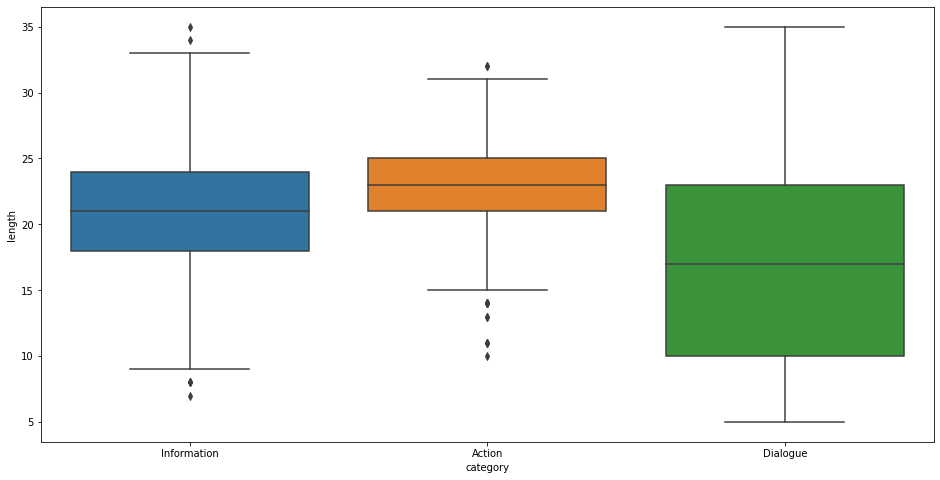

In [30]:
# create a new column in the original dataset - 'length' to capture length of each text
data['length'] = data['text'].apply(lambda x: len(word_tokenize(x)))

# use seaborn boxplot to visualize the pattern in length for each category
fig = plt.figure(figsize=(16,8))
sns.boxplot(x = 'category', y='length', data=data)

In [31]:
# create a new column in the original dataset - 'url_count' to capture total count of urls present in each text
data['url_count'] = data['text'].apply(lambda x: len(re.findall(url_regex, x)))

# use pandas crosstab to see the distibution of different url counts in each category
pd.crosstab(data['category'], data['url_count'], normalize=True)

url_count,0,1,2
category,,,
Action,0.014565,0.166042,0.009155
Dialogue,0.032876,0.018727,0.000000
Information,0.205576,0.533916,0.019143


### Task 4: Creating custom transformers

An estimator is any object that learns from data, whether it's a classification, regression, or clustering algorithm, or a transformer that extracts or filters useful features from raw data. Since estimators learn from data, they each must have a `fit` method that takes a dataset.

There are two kinds of estimators - `Transformer Estimators` i.e. transformers in short and `Predictor Estimators` i.e. predictor in short. In transformers we also need to have another method `transform` and predictors need to have another method `predict`.

Some examples of `transformers` are - CountVectorizer, TfidfVectorizer, MinMaxScaler, StandardScaler etc

Some examples of `predictors` are - LinearRegression, LogisticRegression, RandomForestClassifier etc

In [32]:
# create a custom transformer LengthExtractor to extract length of each sentences

from sklearn.base import BaseEstimator, TransformerMixin
class LengthExtractor(BaseEstimator, TransformerMixin):
    
    def compute_length(self, text):
        sentence_list = word_tokenize(text)
        return len(sentence_list)
    
    def fit(self, x, y=None):
        return self
    def transform(self, X):
        X_length = pd.Series(X).apply(self.compute_length)
        return pd.DataFrame(X_length)


In [33]:
# create a custom transformer UrlCounter to count number of urls in each sentences

class UrlCounter(BaseEstimator, TransformerMixin):
    
    def count_url(self, text):
        urls = re.findall(url_regex, text)
        return len(urls)
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        url_count = pd.Series(X).apply(self.count_url)
        return pd.DataFrame(url_count)

### Task 5: Model Building using FeatureUnion

Feature union applies a list of transformer objects in parallel to the input data, then concatenates the results. This is useful to combine several feature extraction mechanisms into a single transformer.

![alt text](pipeline.png "nlp pipeline")

In [34]:
# import RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# import Pipeline and FeatureUnion from sklearn
from sklearn.pipeline import Pipeline, FeatureUnion

# import CountVectorizer, TfidfTransformer from sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [35]:
# create an instance of Pipeline class
pipeline = Pipeline([


    
        # create a FeatureUnion pipeline
        ('features', FeatureUnion([
    
            # add a pipeline element to extract features using CountVectorizer and TfidfTransformer
            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),

            # add the pipeline element - LengthExtractor to extract lenght of each sentence as feature
            ('text_len', LengthExtractor()),
            
            # add another pipeline element - UrlCounter to extract url counts in each sentence as feature
            ('url_count', UrlCounter())
        ])),
        # use the predictor estimator RandomForestClassifier to train the model
        ('clf', RandomForestClassifier())
])


In [36]:
# split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)


In [37]:
# use pipeline.fit method to train the model

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenize at 0x000001E52391DAF0>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('text_len', LengthExtractor()),
                                                ('url_count', UrlCounter())])),
                ('clf', RandomForestClassifier())])

### Task 6: Model Evaluation

Now, once the model is trained, in this task we will evaluate how the model behaves in the test data

In [38]:
# use the method pipeline.predict on X_test data to predict the labels
y_pred = pipeline.predict(X_test)


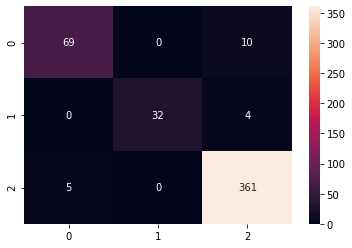

In [40]:
# create the confustion matrix, import confusion_matrix from sklearn
from sklearn.metrics import confusion_matrix

# count the number of labels
labels = np.unique(y_pred)

# use sns.heatmap on top of confusion_matrix to show the confusuin matrix
sns.heatmap(confusion_matrix(y_test, y_pred, labels=labels), annot=True, fmt = '.0f')

In [41]:
# create the classification report, import classification_report from sklearn
from sklearn.metrics import classification_report

# apply the function classification_report on y_test, y_pred and print it
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.93      0.87      0.90        79
    Dialogue       1.00      0.89      0.94        36
 Information       0.96      0.99      0.97       366

    accuracy                           0.96       481
   macro avg       0.97      0.92      0.94       481
weighted avg       0.96      0.96      0.96       481



### Task 7: Conclusion and next steps

How to improve this model - 

- hyper parameter tuning
- more feature engineering
- feature selection
- trying different predictors